In [41]:
a = np.arange(12)
a[10:0:-2]

array([10,  8,  6,  4,  2])

In [75]:
class HistoricAverage:
    def __init__(self, step=1):
        self.step = step

    def __call__(self, a):
        r = np.empty(a.shape)
        r.fill(np.nan)
        for i in range(self.step+1,len(r)):
            x = np.mean(a[i-self.step+1:0:-self.step], axis=0)   # todo should start at future date and steps backward - should not include crimes of time n - 1
            r[i] = x

        return r

In [125]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

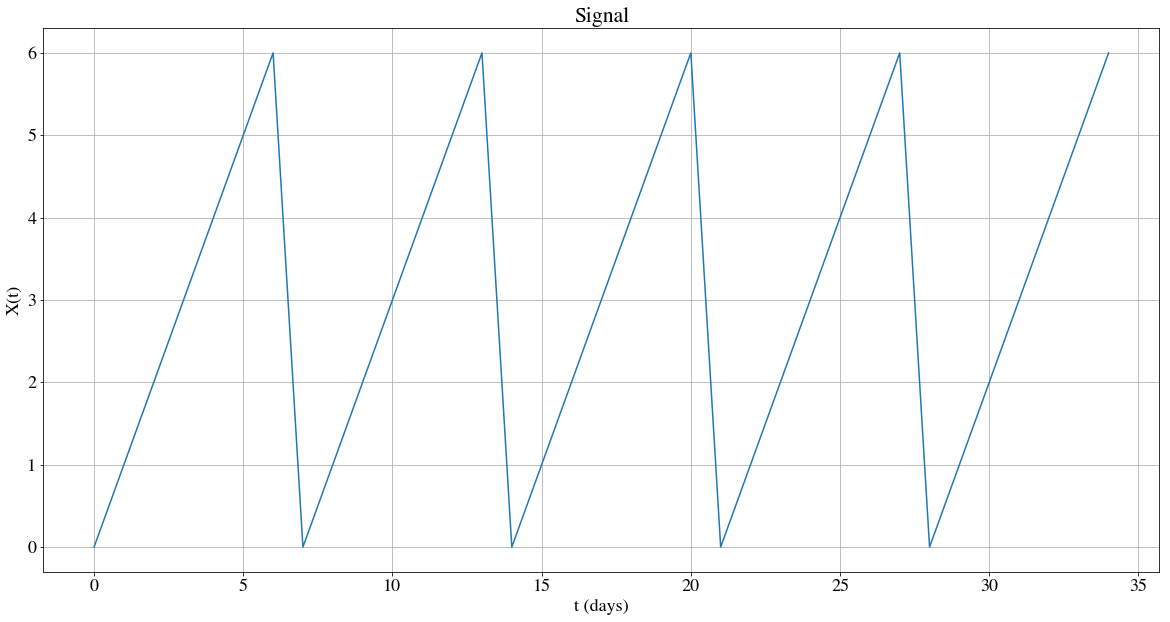

In [175]:


Fs = 1 # folding freq is 0.5*fs and should be larger than highest freq
T = 1/Fs             
L = 35  
t = np.arange(L)*T

# f0 = 50
# f1 = 120


y = t % 7#0.7*np.sin(2*np.pi*f0*t) + np.sin(2*np.pi*f1*t) #+ 2*np.random.randn(L)

plt.figure(figsize=(20,10))
plt.plot(t,y)
plt.title("Signal")
plt.ylabel("X(t)")
plt.xlabel("t (days)")
plt.grid()
plt.show()

0


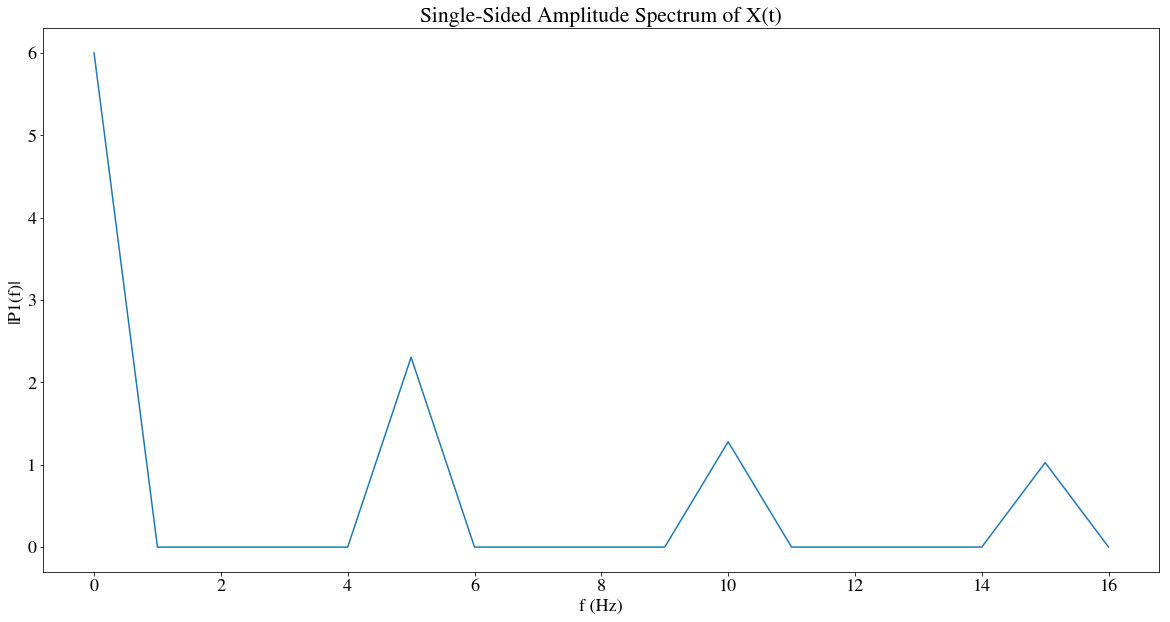

In [177]:
z = np.fft.fft(y)
P2 = np.abs(z/L)
P1 = P2[:L//2]
# P1[1:] = 2*P1[1:]
P1 = 2*P1

f = Fs*np.arange(0,L//2)
plt.figure(figsize=(20,10))
plt.plot(f,P1) 
plt.title('Single-Sided Amplitude Spectrum of X(t)')
plt.xlabel('f (Hz)')
plt.ylabel('|P1(f)|')

print(f[P1.argmax()])

In [185]:
r = np.arange(10)
np.random.shuffle(r)


array([8, 7, 5, 2, 4, 6, 9, 1, 3, 0])

20


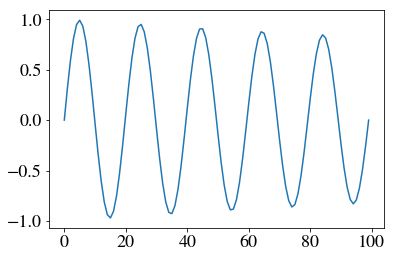

In [220]:
y = np.sin(x)*np.exp2(-.009*x)
plt.plot(y)
print(get_period(y))

In [192]:
def roll_corr(a):
    n = len(a)
    corr_list = []
    for i in range(n):
        corr = np.correlate(a,np.roll(a,i))
        corr_list.append(corr)
    out =np.array(corr_list)
    out[out < 0] = 0
    return out[:,0]

95


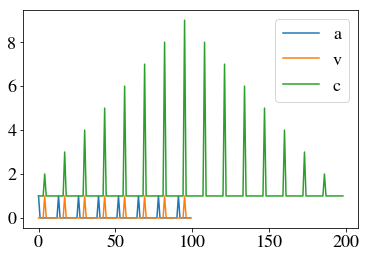

In [98]:
from scipy.signal import correlate
step = 13
delay = 4
a = np.zeros(100)
a[::step] = 1
v = np.roll(a,delay)
c = correlate(a,v)
plt.plot(a,label="a")
plt.plot(v,label="v")
plt.plot(c+1,label="c")
print(np.argmax(c))
plt.legend()
plt.show()

In [224]:
def get_period(a):
    n = len(a)
    corr_list = []
    for i in range(n):
        corr = np.correlate(a,np.roll(a,i))
        corr_list.append(corr)
    r = np.array(corr_list)[:,0]
    r[r < 0] = 0
    argsort = np.argsort(r)[::-1]
    option1 = argsort[1]
    option2 = argsort[2]
    gcd = np.gcd(option1,option2)
    if gcd in [option1,option2]:
        period = gcd
    else:
        period = option1
    return period

In [259]:
np.gcd(10,8)

2

step: 24


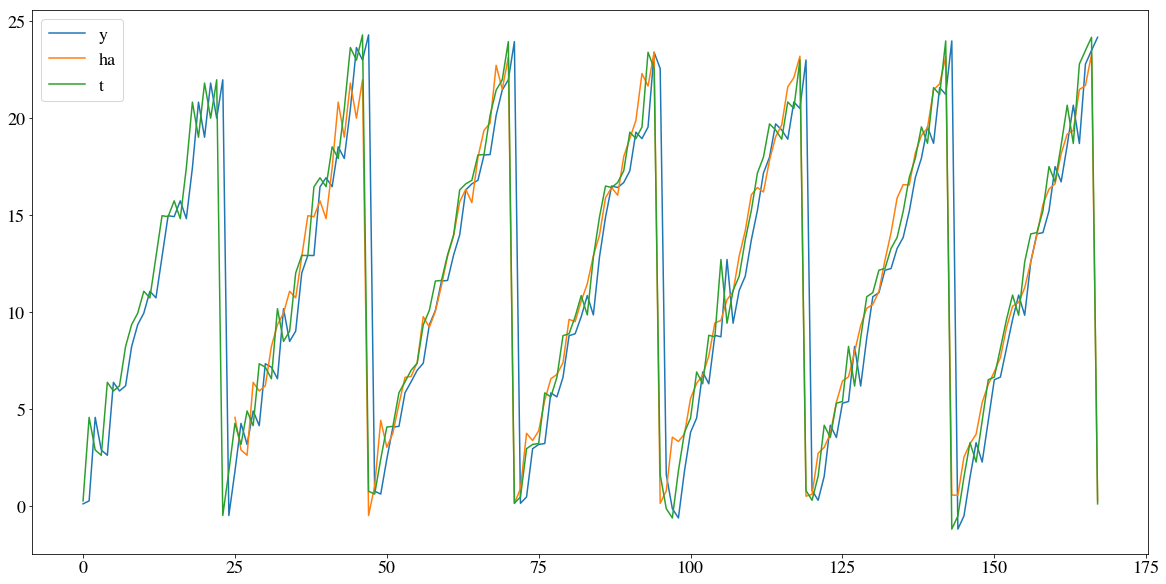

In [255]:
x = np.arange(24*7)
y = x % 24 + np.random.randn(len(x))
step = get_period(y)
print(f"step: {step}")
ha = HistoricAverage(step=step)


t = np.copy(y)
t = np.roll(t,-1)
plt.figure(figsize=(20,10))
plt.plot(y,label='y')
plt.plot(ha(y),label="ha")
plt.plot(t,label='t')
plt.legend()
plt.show()

In [ ]:
def get_historic_average(a, step=24):
    """
    a: array (N,d) or (N,d,d)
    step: the historic step the average is taken over, e.g. 24 for every 24 hours
    """
    ha = []  # historic averages

    for i in range(step):
        ha.append(a[i::step].mean(0))

    b = -1 * np.ones_like(a)  # minus one there to check if anything went wrong
    for i in range(len(b)):
        b[i] = ha[i % step]

    return b

# note: do evaluation in (N,C,L) format, this way the accuracy is better reflected, and we still get stel predictions over time

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold
from models.model_result import ModelResult
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, TriangularMovingAverage

In [3]:
conf_dict = {
    "seed":3,
    "resume":True,
    "early_stopping":False,
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,    
    "use_cuda":False,
    "val_ratio":0.1,
    "tst_ratio":0.2,
    "flatten_grid": True,
    "lr":1e-3,
    "weight_decay":1e-8,
    "max_epochs":5,
    "batch_size":256,
    "dropout": 0,
    "shuffle":False,
    "seq_len":0,
}

conf = BaseConf(conf_dict)

data_dim_str = "T24H-X850M-Y880M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}/"
os.makedirs(data_path, exist_ok=True)

In [4]:
data_group = GridDataGroup(data_path=data_path, conf=conf)

#### Mean of training data as future prediction

In [5]:
# Mean of training data as future prediction

trn_crimes = data_group.training_set.crimes

crimes_mean = np.mean(trn_crimes[:,0],axis=0,keepdims=True)
crimes_ones = np.ones_like(data_group.testing_set.targets)
y_pred_sparse = crimes_mean*crimes_ones
targets_dense = data_group.shaper.squeeze(data_group.testing_set.targets)
y_pred_dense = data_group.shaper.squeeze(y_pred_sparse)

probas_pred = y_pred_dense.flatten()
y_true = targets_dense.flatten()
thresh = best_threshold(y_true, probas_pred)
y_pred = np.copy(probas_pred)
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh] = 0

mean_model_result = ModelResult(model_name="Train Mean",
                     y_true=y_true,
                     y_pred=y_pred,
                     probas_pred=probas_pred)

f1_score: 0.6969299887682516 at index 288, new threshold -0.8047743504343398


#### Rolling mean of all data 

In [32]:
model_results = []

for window_len in [16,32,64]:
    uma = TriangularMovingAverage(window_len=window_len)
    all_crimes = data_group.crimes[:,0]
    tst_targets = data_group.testing_set.targets
    all_crimes_ma = uma(all_crimes)
    tst_crimes_ma = all_crimes_ma[-len(tst_targets):]

    targets_dense = data_group.shaper.squeeze(tst_targets)
    y_pred_dense = data_group.shaper.squeeze(tst_crimes_ma)

    probas_pred = y_pred_dense.flatten()
    y_true = targets_dense.flatten()

    print(f"{y_true.shape}, {probas_pred.shape}")

    thresh = best_threshold(y_true, probas_pred)
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    uma_model_result = ModelResult(model_name=f"UMA {window_len}",
                         y_true=y_true,
                         y_pred=y_pred,
                         probas_pred=probas_pred)
    model_results.append(uma_model_result)

(54936,), (54936,)
f1_score: 0.6841456242530022 at index 1694, new threshold -0.8219240219448665
(54936,), (54936,)
f1_score: 0.6911734627470669 at index 7573, new threshold -0.8264051133963833
(54936,), (54936,)
f1_score: 0.6946436976372022 at index 14743, new threshold -0.8130245506285864


UMA 16
	Accuracy:		 0.6969
	ROC AUC:		 0.7935
	Average Precision:	 0.7200
UMA 32
	Accuracy:		 0.6977
	ROC AUC:		 0.8025
	Average Precision:	 0.7302
UMA 64
	Accuracy:		 0.7048
	ROC AUC:		 0.8073
	Average Precision:	 0.7354
Train Mean
	Accuracy:		 0.7053
	ROC AUC:		 0.8092
	Average Precision:	 0.7364


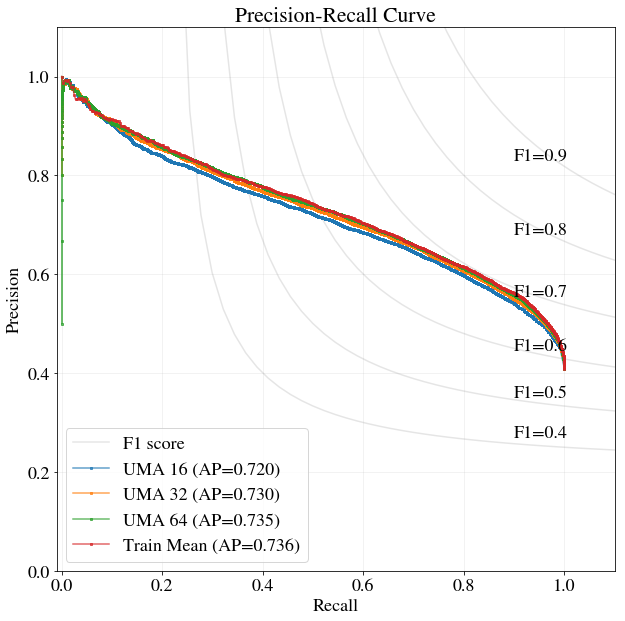

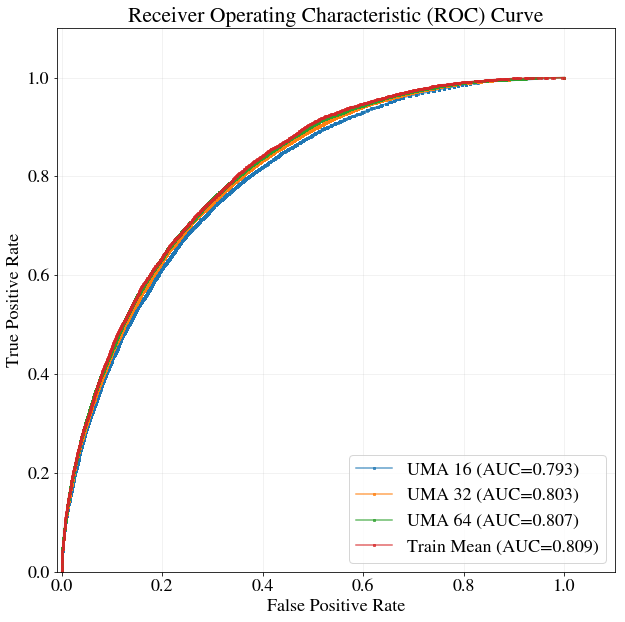

In [33]:
model_results.append(mean_model_result)
for result in model_results:
    print(f"{result.model_name}")
    print(f"\tAccuracy:\t\t {result.accuracy:.4f}")
    print(f"\tROC AUC:\t\t {result.roc_auc:.4f}")
    print(f"\tAverage Precision:\t {result.average_precision:.4f}")


pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

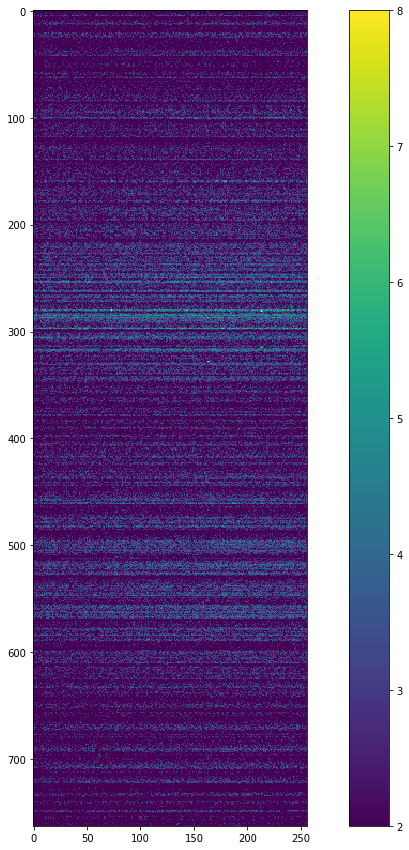

In [184]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
im(np.exp2(2+ squeezed_crimes[:,0].T))

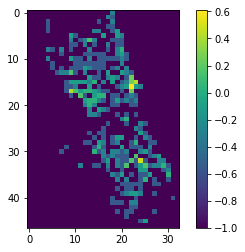

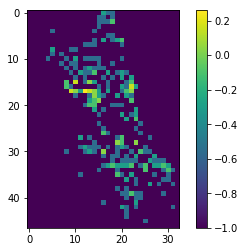

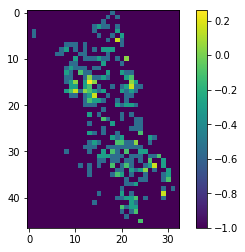

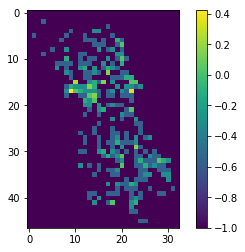

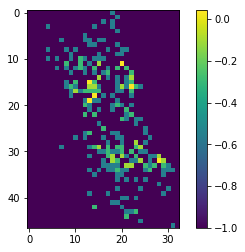

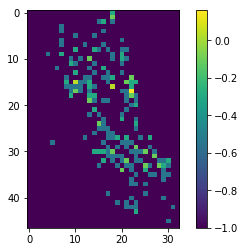

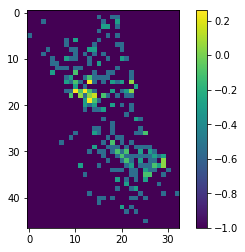

In [169]:
c = 0
for i in range(7):
    im(data_group.training_set.crimes[i,c]) 


In [115]:
# running average but pad witht the first 
import numpy as np
import pandas as pd
from torch import nn


class LinearRegressor(nn.Module):
    def __init__(self, in_features=10, out_features=2):
        super(LinearRegressor, self).__init__()

        self.linear = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.activation(self.linear(x))

        return out


# TODO CONVERT FUNCTIONS INTO A CLASS
# still needs to do it only on training data average no the total
def get_historic_average(a, step=24):
    """
    a: array (N,d) or (N,d,d)
    step: the historic step the average is taken over, e.g. 24 for every 24 hours
    """
    ha = []  # historic averages

    for i in range(step):
        ha.append(a[i::step].mean(0))

    b = -1 * np.ones_like(a)  # minus one there to check if anything went wrong
    for i in range(len(b)):
        b[i] = ha[i % step]

    return b


def rolling_apply(fun, a, w):  # this rolling average includes the current time step
    r = np.empty(a.shape)
    r.fill(np.nan)
    for i in range(w - 1, a.shape[0]):
        r[i] = fun(a[(i - w + 1):i + 1])
    return r

def rolling_avg(fun, a, weights):  # this rolling average includes the current time step
    w = len(weights)
    r = np.empty(a.shape)
    r.fill(np.nan)
    for i in range(w - 1, a.shape[0]):
        x = a[(i - w + 1):i + 1]
        r[i] = fun(x, weights)

    return r

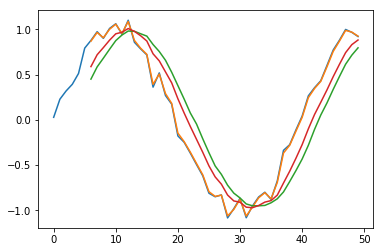

In [161]:
ema = ExponentialMovingAverage(alpha=100,window_len=7)
uma = UniformMovingAverage(window_len=7)
tma = TriangularMovingAverage(window_len=7)

plt.plot(a)
plt.plot(ema(a))
plt.plot(uma(a))
plt.plot(tma(a))
plt.show()

(50, 1)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


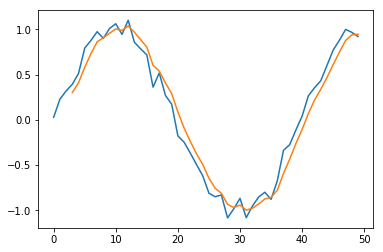

In [142]:
window = 4
weights = np.exp(-100 / np.arange(1+window+1))
weights = np.arange(1,window+1)
# weights = np.ones(window)


f_avg = lambda x, weights: np.average(x, axis=0, weights=weights)
n = 50
a = np.sin(np.arange(n)/np.pi/2) + np.random.randn(n)/10
a = np.expand_dims(a, axis=1)
print(a.shape)
b = rolling_avg(f_avg, a,weights)


plt.plot(a)
plt.plot(b)

In [85]:
a = np.random.randn(100)

folder = "./data/processed/"

zip_file = np.load(folder + "generated_data.npz")

grids = zip_file["crime_grids"]
t_range = pd.read_pickle(folder + "t_range.pkl")

grids = np.load(folder + 'crimes_grids.npy')
f = lambda x: x.mean(0)
avg = lambda x, weights: np.average(x, axis=0, weights=weights)  # x and weights should have same length
# np.average()


window = 4
weights = np.exp(-10 / np.arange(window))

lag = 1
dT = '1D'
if dT == '1D':
    folder = "./data/processed/T24H-X850M-Y880M/"
    historic_jump = 7
elif dT == '4H':
    folder = "./data/processed/T4H-X850M-Y880M/"
    historic_jump = 24
else:
    folder = "./data/processed/T24H-X850M-Y880M/"
    historic_jump = 1

grids_lag = grids[:-1]
grids = grids[1:]

grids_ma = rolling_apply(f, grids_lag, window)  # use lag because we cannot include today's rate in the MA

grids_avg = rolling_avg(avg, grids, weights)

grids_ha = get_historic_average(grids[:len(grids)], historic_jump)  # use grids as we get average for that time
grids_hama = grids_ha * grids_ma

grids_ha = np.nan_to_num(grids_ha)
grids_ma = np.nan_to_num(grids_ma)
grids_hama = np.nan_to_num(grids_hama)

# skip 10 for window size
grids = grids[window - 1:]
grids_lag = grids_lag[window - 1:]  # can cap too if we're only looking into binary classification

grids_ma = grids_ma[window - 1:]
grids_ha = grids_ha[window - 1:]
grids_hama = grids_hama[window - 1:]
grids_avg = grids_avg[window - 2:]

FileNotFoundError: [Errno 2] No such file or directory: './data/processed/generated_data.npz'

In [ ]:
class ModelResult:
    def __in